In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('MNRAS')
import pandas as pd
#import h5py
import emcee

In [2]:
from chainconsumer import Chain, ChainConsumer, ChainConfig
iz = 0
zid = 3+iz
para_name = 's8Omhod' #'template'#
data_name = 'flamingo' #'abacus_summit' #  #
run_name = para_name
emu_name = 'all' #'wide'#
yml_name = f'yml/emcee_{run_name}_{data_name}.yml'
out_loc = f'/projects/hywu/cluster_sims/cluster_finding/data/emulator_mcmc/{emu_name}/mcmc_{data_name}/'
plot_loc = f'../../plots/emulator/{emu_name}/{data_name}/'
out_file = f'{out_loc}/mcmc_{run_name}_z0.{zid}.h5'
print(out_file)
#out_file = '/projects/hywu/cluster_sims/cluster_finding/data/emulator_mcmc/wide/mcmc_flamingo/mcmc_s8Omhod_z0.3.h5'
reader = emcee.backends.HDFBackend(out_file, read_only=True)

/projects/hywu/cluster_sims/cluster_finding/data/emulator_mcmc/all/mcmc_flamingo//mcmc_s8Omhod_z0.3.h5


In [3]:
from parse_yml import ParseYml
parse = ParseYml(yml_name)
nsteps, nwalkers, lsteps, burnin, params_free_name, params_free_ini, params_range,\
        params_fixed_name, params_fixed_value = parse.parse_yml()

Free parameters:['sigma8', 'OmegaM', 'alpha', 'lgM1', 'lgMcut']


In [4]:
from chainconsumer import Chain, ChainConsumer, Truth, PlotConfig
chain = Chain.from_emcee(reader, columns=parse.params_free_name, name='posterior', color="blue")
c = ChainConsumer()
c.add_chain(chain)

In [5]:
# fig = c.plotter.plot_walks()
# plt.savefig(plot_loc+f'mcmc_walks_{run_name}.pdf', dpi=72)

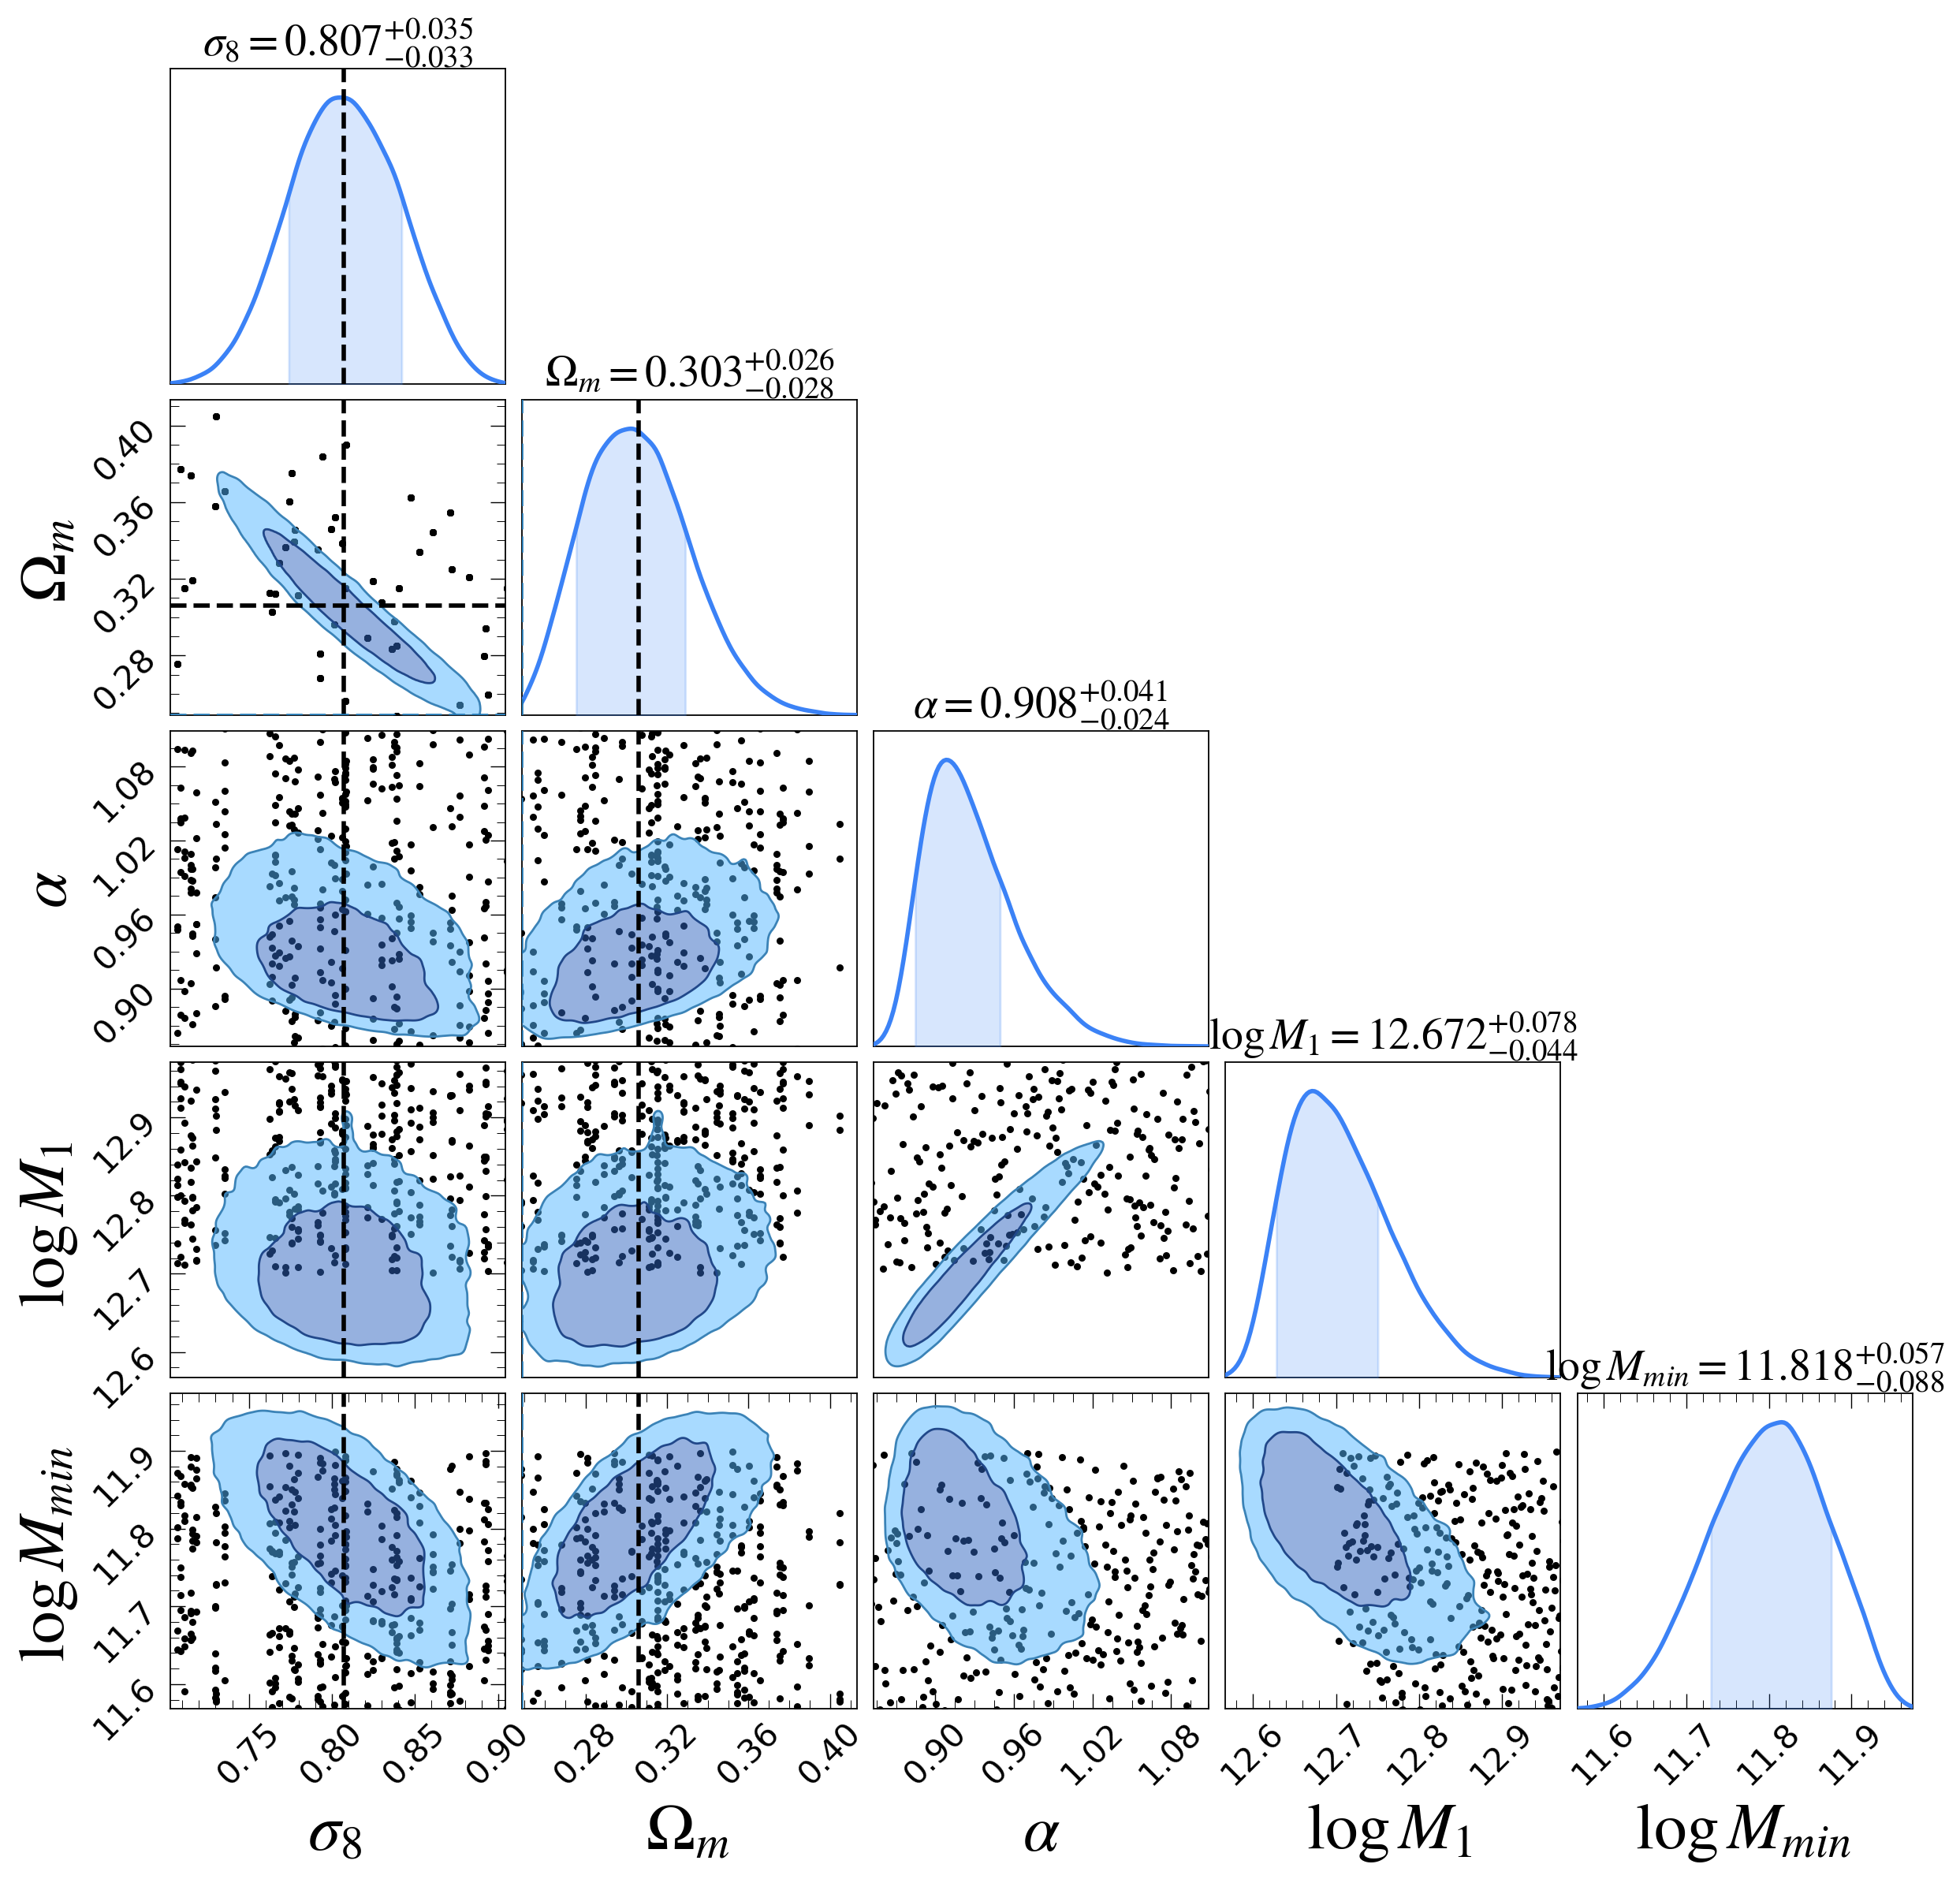

In [6]:
# example
# https://samreay.github.io/ChainConsumer/generated/gallery/advanced_examples/plot_5_multiple_truth_values/


#### plot the truth # set line wideth manually in the end
loc = dict(zip(parse.params_free_name, parse.params_free_truth))
c.add_truth(Truth(location=loc, color='k'))#, linestyle="-", linewidth=20))

#### plot the prior ranges
para_min = dict(zip(parse.params_free_name, parse.params_free_range[:,0]))
para_max = dict(zip(parse.params_free_name, parse.params_free_range[:,1]))
c.add_truth(Truth(location=para_min, color='C0'))#, linestyle=":", linewidth=0.5))
c.add_truth(Truth(location=para_max, color='C0'))#, linestyle=":", linewidth=0.5))

#### latex label, fontsize
lab = dict(zip(parse.params_free_name, parse.params_free_label))
pc = PlotConfig(
        labels=lab,
        label_font_size = 30,
        summary_font_size = 20,
        tick_font_size = 15,
        #tick_font = 'roman'
)
c.set_plot_config(pc)
c.set_override(ChainConfig(shade_alpha=0.5))
fig = c.plotter.plot()

#### Plot the emulator range
loc = '/projects/hywu/cluster_sims/cluster_finding/data/'
emu_name = 'all'
train_loc = loc + f'emulator_train/{emu_name}/train/z0p{zid}00/'

df = pd.read_csv(f'{train_loc}/parameters.csv')
df = df[parse.params_free_name]
# chain_emu = Chain(samples=df, name="emulator") 
# c.add_chain(chain_emu)

ndim = len(parse.params_free_name)
data = df.to_numpy()
for i in range(0, ndim):
    for j in range(0, ndim):
        ax = plt.subplot(ndim, ndim,1+ndim*j+i)
        if j > i:
            ax.scatter(data[:, i], data[:, j], s=5, alpha=1, color='k')

        if True:
            # also set up plotting style
            ax.grid(False)
            for line in ax.lines:
                #if line.get_linestyle() == "--":
                line.set_linewidth(2)

plt.savefig(plot_loc+f'mcmc_contour_{run_name}.pdf', dpi=72)

In [7]:
#### Plot posterior
# Sample 5000 points from the chain
# Use emulator to calculate the posterior
flat_samples = reader.get_chain(discard=100, thin=10, flat=True)
print('after thinning', flat_samples.shape)
nsamples, ndim = flat_samples.shape
nsub = 500
idx = np.random.randint(0, nsamples, size=nsub)
subsample = flat_samples[idx]

after thinning (36192, 5)


In [8]:
from get_model import GetModel
gm = GetModel(emu_name, iz, params_free_name, params_fixed_value, params_fixed_name)

data_vec = np.loadtxt(f'../emulator/data_vector_{data_name}/data_vector_z0.{zid}.dat')
cov = np.loadtxt(f'../emulator/data_vector_abacus_summit/cov_z0.{zid}.dat')

# for i in range(nsub):
#     plt.plot(gm.model(subsample[i])/data_vec, c='gray', alpha=0.1)

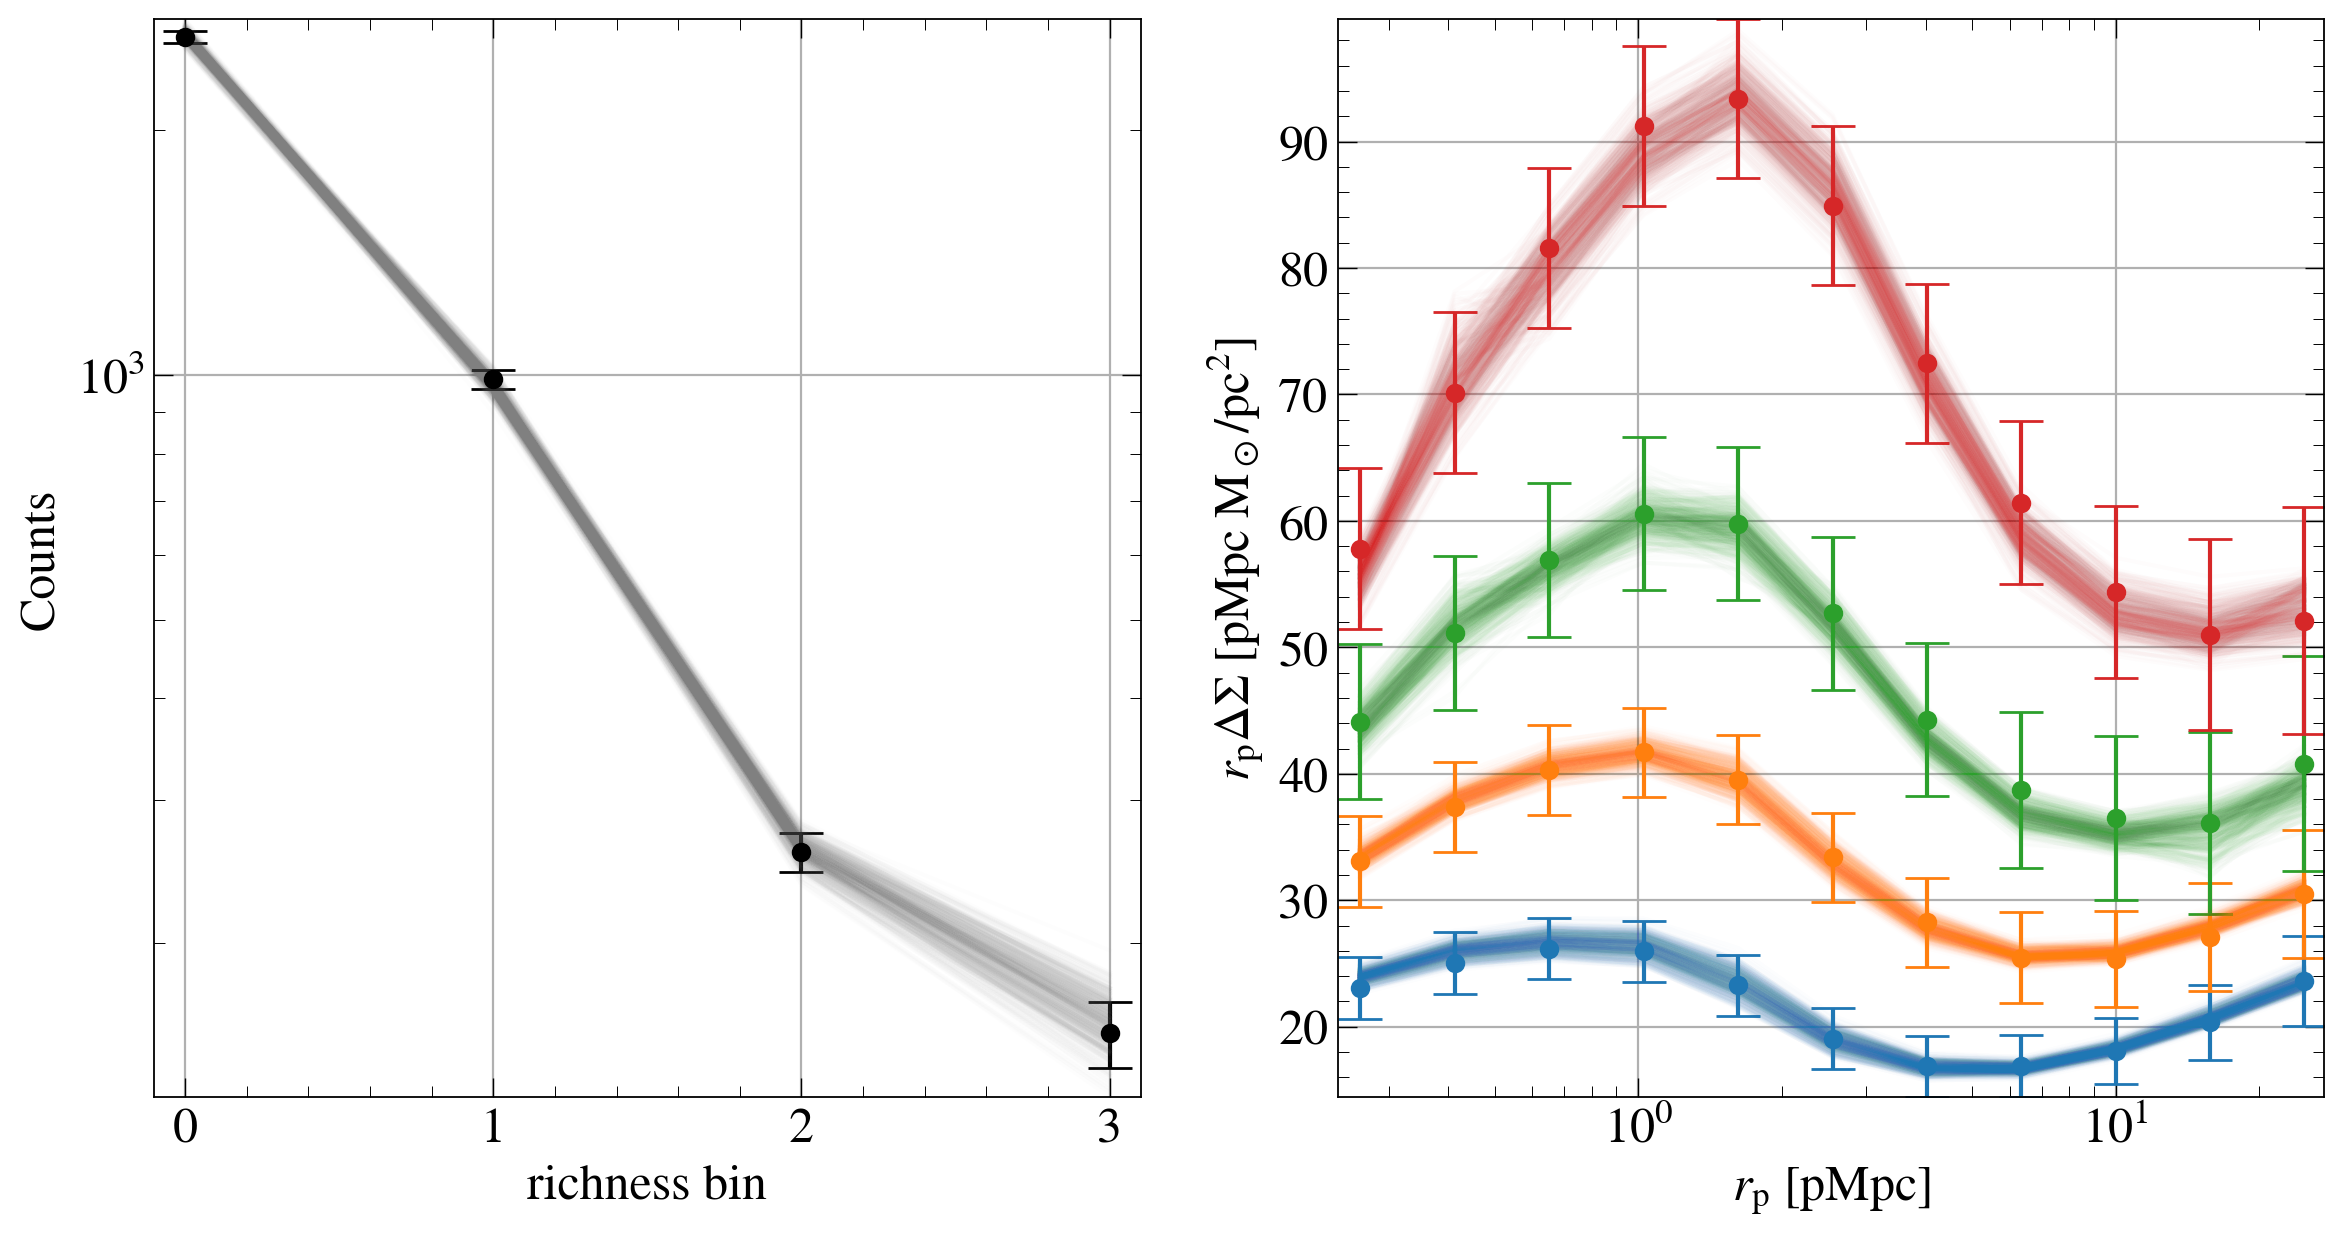

In [9]:
plt.figure(figsize=(14,7))

#### counts
plt.subplot(1,2,1)
x = np.arange(4)
sigma = np.sqrt(np.diag(cov))
plt.errorbar(x, data_vec[0:4], sigma[0:4], c='k', marker='o', mec='k', ls='', capsize=8)
for i in range(nsub):
    plt.plot(x, gm.model(subsample[i])[0:4], c='gray', alpha=0.01)
plt.xlim(-0.1,3.1)
plt.yscale('log')
plt.ylabel('Counts')
plt.xlabel('richness bin')

#### lensing
plt.subplot(1,2,2)
rp = np.loadtxt(train_loc+f'rp_rad.dat')
nrp = len(rp)
lensing_vec = data_vec[4:]
lensing_sigma = sigma[4:]

for ibin in range(4):   
    plt.errorbar(rp, rp*lensing_vec[ibin*nrp:(ibin+1)*nrp], \
        rp*lensing_sigma[ibin*nrp:(ibin+1)*nrp],\
        c=f'C{ibin}', marker='o', mec=f'C{ibin}', ls='', capsize=8)    

for i in range(nsub):
    lensing_model = gm.model(subsample[i])[4:]
    for ibin in range(4):
        plt.plot(rp, rp*lensing_model[ibin*nrp:(ibin+1)*nrp], c=f'C{ibin}', alpha=0.01)    
plt.xlim(0.9*min(rp), 1.1*max(rp))
plt.xscale('log')
plt.xlabel(r'$r_{\rm p}~[{\rm pMpc}]$')
plt.ylabel(r'$r_{\rm p} \Delta\Sigma~[{\rm pMpc ~M_\odot/pc^2} ]$')
plt.savefig(plot_loc+'posterior_prediction.pdf', dpi=72)